# Classifying YouTube Videos for Humpback Whale Encounters - Keras CNN-RNN

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from tensorflow_docs.vis import embed
from tensorflow import keras
from imutils import paths

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import pickle
import glob
import cv2
import os
import time

from sklearn import metrics
from sklearn.model_selection import KFold, StratifiedKFold
import seaborn as sns

In [3]:
#ngc workspace path (where we keep our data)
workspace_path = '/mount/data'

# Start WandB Session

In [4]:
import wandb

#start wandb session for metric logging
wandb.login() 

wandb.init(project="whale-classification-inception")

wandb: Currently logged in as: micheller (epg). Use `wandb login --relogin` to force relogin


# Set GPU Context

In [5]:
print("Num GPUs available: ", len(tf.config.list_physical_devices('GPU'))) #1 if we select GPU mode in Colab Notebook, 0 if running on local machine

Num GPUs available:  2


In [7]:
# gpus = tf.config.list_physical_devices('GPU')
gpus = tf.config.list_logical_devices('GPU')

for gpu in gpus:
    print(gpu.name)

/device:GPU:0
/device:GPU:1


# Inception V3 (CNN-RNN) 

## Hyperparameters

In [8]:
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 10

MAX_NUM_FRAMES = 461
NUM_FEATURES = 2048

461 frames of size 224 x 224 with RGB color channels

# Load Frames + Extract Features with CNN

In [9]:
from feature_extraction import load_frames, prepare_all_videos
from cnn import CNN

In [10]:
#create CNN Feature Extractor
ConvNet = CNN(IMG_SIZE)
feature_extractor = ConvNet.InceptionV3()
feature_extractor

In [12]:
#load dataset in
data = pd.read_csv(workspace_path + '/downloaded_videos.csv')
y = data.pop('relevant')
X = data

In [13]:
#begin keeping track of time to extract ALL frames using a single GPU
start = time.time()

with tf.device('/device:GPU:0'):
    (frame_features, frame_masks), labels = prepare_all_videos(X, y, MAX_NUM_FRAMES, NUM_FEATURES, feature_extractor)
    
stop = time.time()

print(f"Time to extract frames with single GPU: {stop - start}s")

video_0000.mp4


2022-07-11 21:43:32.420158: I tensorflow/stream_executor/cuda/cuda_dnn.cc:379] Loaded cuDNN version 8400


video_0134.mp4
video_0248.mp4
video_0357.mp4
Time to extract frames with single GPU: 18351.396564483643s


In [14]:
#took 5 hours to extract features from frames with the GPU context set above
(stop-start)/60/60

5.097610156801012

In [15]:
print('Frame features shape: ', frame_features.shape)
print('Frame masks shape: ', frame_masks.shape)
print('Number of Labels: ', len(labels))

Frame features shape:  (364, 461, 2048)
Frame masks shape:  (364, 461)
Number of Labels:  364


# Training RNN Sequence Model

In [16]:
from rnn import RNN

rnn_model = RNN()

In [48]:
from sklearn.model_selection import train_test_split

#split data into 80% train, 20% test. Both test and train contain balanced class proportions (half rel, half not rel) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [83]:
from sklearn import metrics

rnn_model = RNN()

train_index = list(X_train.index)
test_index = list(X_test.index)

#index data accordingly
train_features, train_masks, train_labels = frame_features[train_index], frame_masks[train_index], np.array(labels)[train_index]
test_features, test_masks, test_labels = frame_features[test_index], frame_masks[test_index], np.array(labels)[test_index]

#reshape label arrays as horizontal arrays
train_labels = np.reshape(train_labels, (train_labels.shape[0], 1))
test_labels = np.reshape(test_labels, (test_labels.shape[0], 1))

#create and compile model
rnn_model.build_model(MAX_NUM_FRAMES, NUM_FEATURES)
rnn_model.compile_model(loss="sparse_categorical_crossentropy", optimizer="adam", metrics="accuracy")

#train model - 20 epochs gave us 75% accuracy on train
history = rnn_model.fit(train_features, train_masks, train_labels, num_epochs=50, verbose=1)

#evaluate model on test set
loss, accuracy = rnn_model.evaluate(test_features, test_masks, test_labels)

print(f"Loss: {loss}, Accuracy: {accuracy}")

#get f1, precision, recall, support metrics
y_pred = rnn_model.predict(test_features, test_masks)
y_true = test_labels.flatten()

cm = metrics.confusion_matrix(y_true, y_pred)
precision, recall, f1, support =  metrics.precision_recall_fscore_support(y_true, y_pred)

print(f"F1: {f1}, Precision: {precision}, Recall: {recall}")

Epoch 1/50
8/8 [==============================] - 19s 924ms/step - loss: 0.7306 - accuracy: 0.5259 - val_loss: 0.6744 - val_accuracy: 0.5593
Epoch 2/50
8/8 [==============================] - 1s 110ms/step - loss: 0.7050 - accuracy: 0.5129 - val_loss: 0.6580 - val_accuracy: 0.6441
Epoch 3/50
8/8 [==============================] - 1s 98ms/step - loss: 0.6726 - accuracy: 0.6293 - val_loss: 0.6475 - val_accuracy: 0.6271
Epoch 4/50
8/8 [==============================] - 1s 103ms/step - loss: 0.6416 - accuracy: 0.6509 - val_loss: 0.6413 - val_accuracy: 0.6441
Epoch 5/50
8/8 [==============================] - 1s 110ms/step - loss: 0.6299 - accuracy: 0.6638 - val_loss: 0.6219 - val_accuracy: 0.7458
Epoch 6/50
8/8 [==============================] - 1s 102ms/step - loss: 0.6027 - accuracy: 0.7112 - val_loss: 0.6029 - val_accuracy: 0.7458
Epoch 7/50
8/8 [==============================] - 1s 107ms/step - loss: 0.5748 - accuracy: 0.7414 - val_loss: 0.5758 - val_accuracy: 0.7797
Epoch 8/50
8/8 [====

In [87]:
#log training and validation metrics on wandb

for epoch, train_loss in enumerate(history.history['loss']):
    wandb.log({'training_loss': train_loss, "epoch": epoch})
    
for epoch, train_acc in enumerate(history.history['accuracy']):
    wandb.log({'training_accuracy': train_acc, "epoch": epoch})
    
for epoch, val_loss in enumerate(history.history['val_loss']):
    wandb.log({'val_loss': val_loss, "epoch": epoch})
    
for epoch, val_acc in enumerate(history.history['val_accuracy']):
    wandb.log({'val_accuracy': val_acc, "epoch": epoch})
    
print('Done Logging WandB metrics.')

0 0.7306331396102905
1 0.7050151228904724
2 0.6725813150405884
3 0.6416107416152954
4 0.6298727989196777
5 0.6026502251625061
6 0.5748448371887207
7 0.5475538969039917
8 0.5058477520942688
9 0.5187829732894897
10 0.49085626006126404
11 0.45508161187171936
12 0.41788601875305176
13 0.38626325130462646
14 0.36777547001838684
15 0.3666495382785797


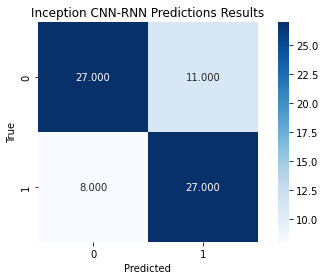

In [85]:
#plot confusion matrix
sns.heatmap(cm, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('True')
plt.xlabel('Predicted')
plt.title('Inception CNN-RNN Predictions Results')
plt.tight_layout()

# Close WandB Session

In [ ]:
wandb.finish()

## TF Distribute

Trying out this example: https://keras.io/guides/distributed_training/

In [65]:
def get_compiled_model():
    # Make a simple 2-layer densely-connected neural network.
    inputs = keras.Input(shape=(784,))
    x = keras.layers.Dense(256, activation="relu")(inputs)
    x = keras.layers.Dense(256, activation="relu")(x)
    outputs = keras.layers.Dense(10)(x)
    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
    )
    return model


def get_dataset():
    batch_size = 32
    num_val_samples = 10000

    # Return the MNIST dataset in the form of a [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset).
    (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

    # Preprocess the data (these are Numpy arrays)
    x_train = x_train.reshape(-1, 784).astype("float32") / 255
    x_test = x_test.reshape(-1, 784).astype("float32") / 255
    y_train = y_train.astype("float32")
    y_test = y_test.astype("float32")

    # Reserve num_val_samples samples for validation
    x_val = x_train[-num_val_samples:]
    y_val = y_train[-num_val_samples:]
    x_train = x_train[:-num_val_samples]
    y_train = y_train[:-num_val_samples]
    return (
        tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size),
        tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(batch_size),
        tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size),
    )


# Create a MirroredStrategy.
strategy = tf.distribute.MirroredStrategy()
print("Number of devices: {}".format(strategy.num_replicas_in_sync))

# Open a strategy scope.
with strategy.scope():
    # Everything that creates variables should be under the strategy scope.
    # In general this is only model construction & `compile()`.
    model = get_compiled_model()

# Train the model on all available devices.
train_dataset, val_dataset, test_dataset = get_dataset()
model.fit(train_dataset, epochs=2, validation_data=val_dataset)

# Test the model on all available devices.
model.evaluate(test_dataset)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:

2022-07-12 14:06:31.915603: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_FLOAT
      type: DT_FLOAT
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 50000
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\027TensorSliceDataset:1596"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 784
        }
      }
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT

Epoch 1/2
INFO:tensorflow:batch_all_reduce: 6 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 6 all-reduces with algorithm = nccl, num_packs = 1
1556/1563 [============================>.] - ETA: 0s - loss: 0.2245 - sparse_categorical_accuracy: 0.9325

2022-07-12 14:06:46.769076: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_FLOAT
      type: DT_FLOAT
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 10000
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\027TensorSliceDataset:1598"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 784
        }
      }
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT

1563/1563 [==============================] - 17s 8ms/step - loss: 0.2245 - sparse_categorical_accuracy: 0.9326 - val_loss: 0.1296 - val_sparse_categorical_accuracy: 0.9594
Epoch 2/2
1563/1563 [==============================] - 11s 7ms/step - loss: 0.0907 - sparse_categorical_accuracy: 0.9728 - val_loss: 0.0976 - val_sparse_categorical_accuracy: 0.9705


2022-07-12 14:07:00.956686: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_FLOAT
      type: DT_FLOAT
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 10000
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\027TensorSliceDataset:1600"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 784
        }
      }
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT

313/313 [==============================] - 2s 4ms/step - loss: 0.0995 - sparse_categorical_accuracy: 0.9691


[0.09954466670751572, 0.9690999984741211]